# Omdena  - Milan Chapter Agrifoods
## AI for Sustainable agri-food systems: use of Satellite Imagery
### Exploratory analysis of cereals production in Italy 2020-2022
#### Author: Maria Fisher 


Here we have analysed the major areas and crop produced in Italy. 
Crop dataset used in this study was downloaded from the Italian National Institute of Statistics (Istat).
The objective is to get some insights about crop production and its respective areas in Italy and how climate change have affected crop production in the last 3 years. 



In [1]:
import warnings 
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns 
import scipy 
import sklearn
import geopandas as gpd
import pgeocode
import folium
import sys
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

In [2]:
cereals = pd.read_csv('./Italy_crop_data/italy_cereals.csv',skipinitialspace=True)
cereals.head()

,ITTER107,Territory,TIPO_DATO5,Data type,AGRI_MADRE,Type of crop,TIME,Select time,Value,Flag Codes,Flags
0,ITC11,Torino,ART,total area - hectares,COMMEAT,common wheat,2020,2020,15362,NaN,NaN
1,ITC11,Torino,ART,total area - hectares,COMMEAT,common wheat,2021,2021,16831,NaN,NaN
2,ITC11,Torino,ART,total area - hectares,COMMEAT,common wheat,2022,2022,16735,NaN,NaN
3,ITC11,Torino,TP_QUIN_EXT,total production - quintals,COMMEAT,common wheat,2020,2020,844910,NaN,NaN
4,ITC11,Torino,TP_QUIN_EXT,total production - quintals,COMMEAT,common wheat,2021,2021,925705,NaN,NaN


## Pre-processing dataset 

In [3]:
# Drop Columns
cereals = cereals.drop(columns =['ITTER107','TIPO_DATO5','AGRI_MADRE', 'TIME', 'Flag Codes','Flags' ])
cereals

,Territory,Data type,Type of crop,Select time,Value
0,Torino,total area - hectares,common wheat,2020,15362
1,Torino,total area - hectares,common wheat,2021,16831
2,Torino,total area - hectares,common wheat,2022,16735
3,Torino,total production - quintals,common wheat,2020,844910
4,Torino,total production - quintals,common wheat,2021,925705
...,...,...,...,...,...
12125,Pesaro e Urbino,total area - hectares,rye and winter cereal mixtures (maslin),2022,3
12126,Roma,total area - hectares,rye and winter cereal mixtures (maslin),2022,20
12127,Valle d'Aosta / Vallée d'Aoste,total area - hectares,winter barley,2022,1
12128,Torino,total area - hectares,spring barley,2022,220


In [4]:
# Rename Columns
cereals = cereals.rename(columns = {'Select time':'Year', 'Type of crop':'Type_crop', 'Data type':'Data_type', 'Territory':'City'})


In [5]:
def show_info(cereals):
    print('DATASET SHAPE: ', cereals.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(cereals.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(cereals.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(cereals.isnull().sum())
show_info(cereals)

DATASET SHAPE:  (12130, 5) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12130 entries, 0 to 12129
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   City       12130 non-null  object
 1   Data_type  12130 non-null  object
 2   Type_crop  12130 non-null  object
 3   Year       12130 non-null  int64 
 4   Value      12130 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 474.0+ KB
None

 --------------------------------------------------
NUMBER OF UNIQUE VALUES PER FEATURE: 

City          107
Data_type       3
Type_crop      24
Year            3
Value        3103
dtype: int64

 --------------------------------------------------
NULL VALUES PER FEATURE
City         0
Data_type    0
Type_crop    0
Year         0
Value        0
dtype: int64


## Cities in Italy producing cereals

In [6]:
cereals.City.unique()


array(['Torino', 'Vercelli', 'Biella', 'Verbano-Cusio-Ossola', 'Novara',
       'Cuneo', 'Asti', 'Alessandria', "Valle d'Aosta / Vallée d'Aoste",
       'Savona', 'Genova', 'La Spezia', 'Varese', 'Como', 'Lecco',
       'Sondrio', 'Milano', 'Bergamo', 'Brescia', 'Pavia', 'Lodi',
       'Cremona', 'Mantova', 'Trentino Alto Adige / Südtirol', 'Verona',
       'Vicenza', 'Belluno', 'Treviso', 'Venezia', 'Padova', 'Rovigo',
       'Pordenone', 'Udine', 'Gorizia', 'Piacenza', 'Parma',
       "Reggio nell'Emilia", 'Modena', 'Bologna', 'Ferrara', 'Ravenna',
       'Forlì-Cesena', 'Rimini', 'Massa-Carrara', 'Lucca', 'Pistoia',
       'Firenze', 'Prato', 'Livorno', 'Pisa', 'Arezzo', 'Siena',
       'Grosseto', 'Perugia', 'Terni', 'Pesaro e Urbino', 'Ancona',
       'Macerata', 'Ascoli Piceno', 'Viterbo', 'Rieti', 'Roma', 'Latina',
       'Frosinone', 'Abruzzo', "L'Aquila", 'Teramo', 'Pescara', 'Chieti',
       'Isernia', 'Campobasso', 'Caserta', 'Benevento', 'Avellino',
       'Salerno', 'Foggi

In [7]:
#cereals.Data_type.unique()

## Select only Values for total production - quintals
In general crop production is reported in tonnes per hectare , however Istat (http://dati.istat.it) does not give variables definition, so we have assumed that the column 'Value' for rows containing data for 'harvested production - quintals', are values for total production of cereals. 

In [8]:
cereals_total_prod = cereals[cereals['Data_type'] == 'total production - quintals ']
cereals_total_prod.head()

,City,Data_type,Type_crop,Year,Value
3,Torino,total production - quintals,common wheat,2020,844910
4,Torino,total production - quintals,common wheat,2021,925705
5,Torino,total production - quintals,common wheat,2022,836750
12,Vercelli,total production - quintals,common wheat,2020,64250
13,Vercelli,total production - quintals,common wheat,2021,74550


In [9]:
cereals_total_prod = cereals_total_prod.rename(columns = {'Value':'Total_production'})
cereals_total_prod

,City,Data_type,Type_crop,Year,Total_production
3,Torino,total production - quintals,common wheat,2020,844910
4,Torino,total production - quintals,common wheat,2021,925705
5,Torino,total production - quintals,common wheat,2022,836750
12,Vercelli,total production - quintals,common wheat,2020,64250
13,Vercelli,total production - quintals,common wheat,2021,74550
...,...,...,...,...,...
12059,Trentino Alto Adige / Südtirol,total production - quintals,winter barley,2022,200
12064,Trentino Alto Adige / Südtirol,total production - quintals,spring barley,2021,1890
12065,Trentino Alto Adige / Südtirol,total production - quintals,spring barley,2022,1700
12070,Trentino Alto Adige / Südtirol,total production - quintals,oats and spring cereal mixtures (mixed grain o...,2021,372


In [10]:
cereals_total_prod =cereals_total_prod.drop(columns =['Data_type' ])
cereals_total_prod

,City,Type_crop,Year,Total_production
3,Torino,common wheat,2020,844910
4,Torino,common wheat,2021,925705
5,Torino,common wheat,2022,836750
12,Vercelli,common wheat,2020,64250
13,Vercelli,common wheat,2021,74550
...,...,...,...,...
12059,Trentino Alto Adige / Südtirol,winter barley,2022,200
12064,Trentino Alto Adige / Südtirol,spring barley,2021,1890
12065,Trentino Alto Adige / Südtirol,spring barley,2022,1700
12070,Trentino Alto Adige / Südtirol,oats and spring cereal mixtures (mixed grain o...,2021,372


## Total cereal production in 2020-2022

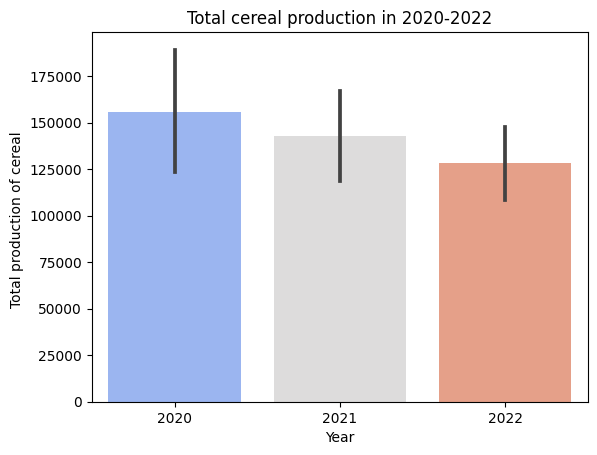

In [11]:

sns.barplot(x= 'Year', y= 'Total_production',data = cereals_total_prod,palette='coolwarm')
plt.title('Total cereal production in 2020-2022')
plt.xlabel('Year')
plt.ylabel('Total production of cereal ')
plt.show()



## Cereal production by Cities 

In [12]:
cereals_total_prod_region = cereals_total_prod.groupby(by = cereals_total_prod.City)['Total_production','City'].sum().reset_index().sort_values(by = 'Total_production', ascending = False).head(10)
cereals_total_prod_region

,City,Total_production
93,Torino,23124980
32,Ferrara,23066682
34,Foggia,22442368
65,Pavia,19838758
29,Cuneo,19837083
82,Rovigo,18998091
51,Mantova,18620664
62,Padova,18030596
100,Venezia,17475472
14,Bologna,16209589


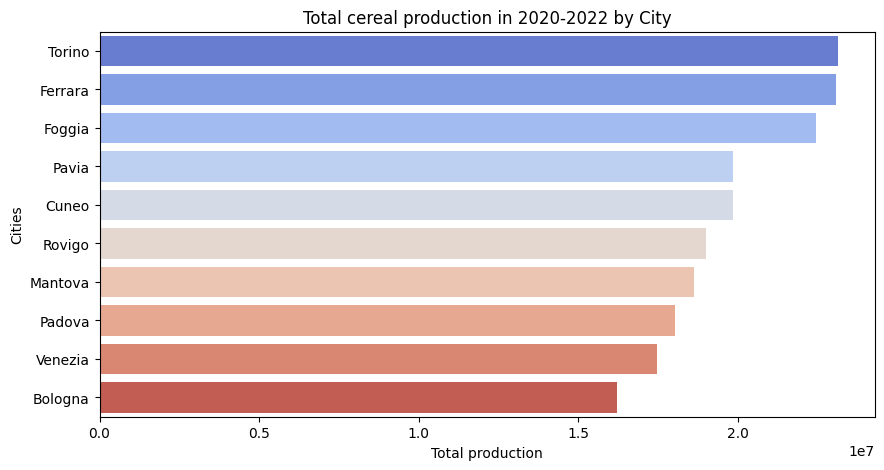

In [13]:
plt.figure(figsize= (10,5))
sns.barplot(x=cereals_total_prod_region['Total_production'],y= cereals_total_prod_region['City'], orient='h', palette='coolwarm');
plt.title('Total cereal production in 2020-2022 by City')
plt.xlabel('Total production')
plt.ylabel('Cities')
plt.show()

## Italy geographic areas is organized in regions, provinces or comunes. 
### The regions are classified as follow:


#### Sud/Mezzogiorno:  

Abruzzo, Apulia/Puglia, Basilicata, Calabria, Campania, Molise, Sicily 

* Abruzzo: L'Aquila, Pescara, Chieti, Teramo

* Apulia/Puglia: Foggia, Bari, Taranto, Brindisi, Lecce, Barletta-Andria-Trani

* Basilicata: Matera, Potenza

* Calabria: Crotone, Vibo, Valentia, Cosenza, Catanzaro, Reggio di Calabria

* Campania: Benevento, Caserta, Napoli, Avellino, Salerno

* Molise: Campobasso, Isernia

* Sicilia: Messina,Siracusa, Agrigento, Caltanissetta, Trapani, Enna, Palermo, Catania, Ragusa

* Sardegna: Oristano, Carbonia-Iglesias, Olbia-Tempio, Ogliastr, Medio Campidano, Sassari, Nuoro, Cagliari



#### Centro: 

Toscana, Umbria, Marche, Lazio

* Toscana: Pistoia, Firenze, Massa-Carrara, Lucca, Arezzo, Livorno, Pisa, Grosseto, Siena, Prato

* Umbria: Perugia, Terni   

* Marche: Ancona, Macerata, Ascoli Piceno, Pesaro e Urbino, Fermo

* Lazio:  Roma, Viterbo, Rieti, Latina, Frosinone


#### Nord-ovest: 

Piemonte, Valle d’Aosta, Lombardia, Liguria

* Liguria: Imperia, Savona, Genova, La Spezia

* Lombardia: Como, Varese, Milano, Pavia, Bergamo, Brescia, Sondrio, Cremona, Mantova, Monza e Della Brianza, Lecco,Lodi

* Piemonte: Vercelli, Novara, Torino, Cuneo, Asti, Alessandria, Biella, Verbano-Cusio-Ossola

* Valdaosta:  Valle d'Aosta


#### Nord-est:

Trentino-Alto Adige, Veneto, Fiuli-Venezia Giulia, Emilia-Romagna


* Trentino: Bolzano/Bozen, Trento

* Veneto:  Belluno, Verona, Vicenza, Rovigo, Treviso, Venezia, Padova

* Friuli: Udine, Gorizia, Trieste, Pordenone

* Emilia-Romagna: Parma, Reggio Nell'Emilia, Piacenza, Forli'-Cesena, Modena, Bologna, Ferrara, Ravenna, Rimini











## Cereals highest production 2020-2022

In [14]:
#print(cereals_total_prod.Type_crop.max())
#print(cereals_total_prod.Type_crop.value_counts())
#print(cereals_total_prod.Type_crop.nunique())



Dataset shows there are 24 different types of cereals cultivated in Italy. The top five most produced crops are Wheat, Barley, Maize, Beans and Oats. 

In [15]:
cereals_total_prod.describe()

,Year,Total_production
count,4042.000000,4.042000e+03
mean,2021.082880,1.411529e+05
std,0.788942,4.820117e+05
min,2020.000000,0.000000e+00
25%,2020.000000,7.200000e+02
50%,2021.000000,5.032500e+03
75%,2022.000000,6.392000e+04
max,2022.000000,7.500000e+06


<AxesSubplot: >

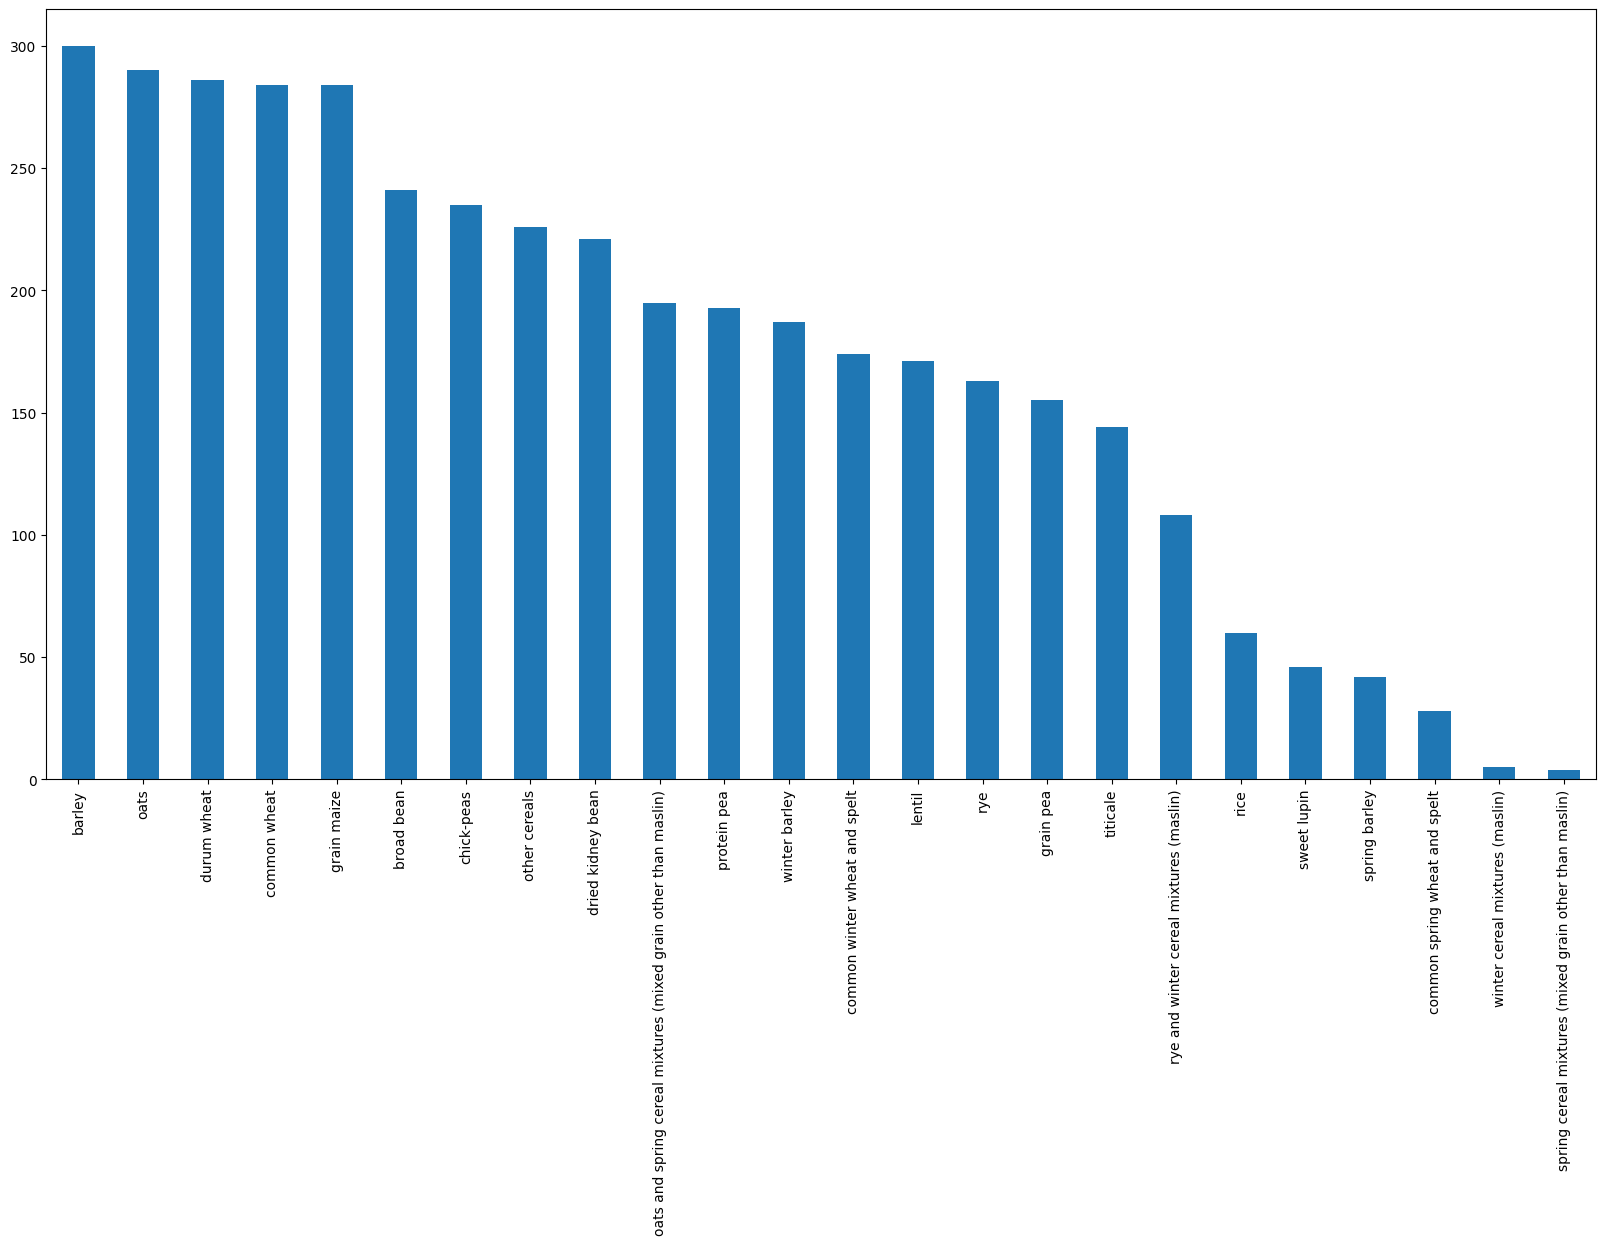

In [16]:
plt.figure(figsize=(20,10))
cereals_total_prod ['Type_crop'].value_counts().plot.bar()

## Subseting data

In [17]:
cereals_top5 = cereals_total_prod.apply(lambda row: row[cereals_total_prod['Type_crop'].isin(['barley','oats', 
                                         'durum wheat','common wheat', 'grain maize'])])

cereals_top5.head()

,City,Type_crop,Year,Total_production
3,Torino,common wheat,2020,844910
4,Torino,common wheat,2021,925705
5,Torino,common wheat,2022,836750
12,Vercelli,common wheat,2020,64250
13,Vercelli,common wheat,2021,74550


## Stats

In [18]:
cereals_top5.describe().astype(int)

,Year,Total_production
count,1444,1444
mean,2020,304659
std,0,696586
min,2020,0
25%,2020,5606
50%,2021,62000
75%,2022,232845
max,2022,7500000


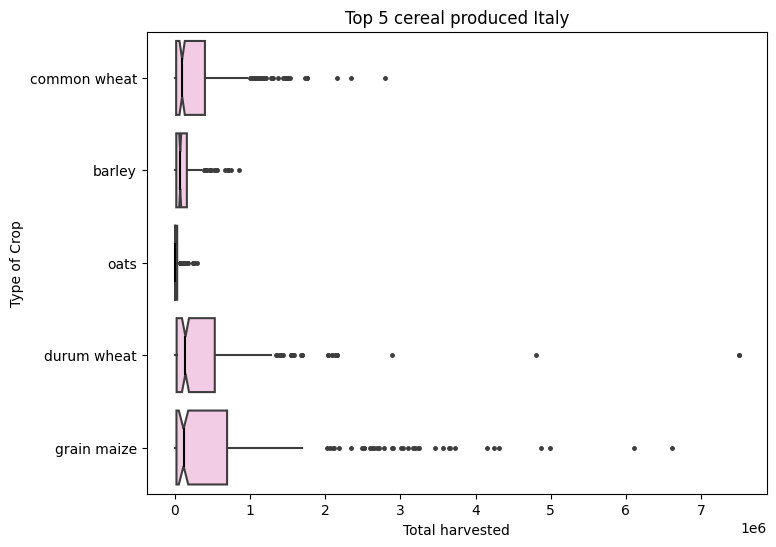

In [19]:
plt.figure(figsize=(8,6))

sns.boxplot(
    data=cereals_top5, y="Type_crop", x="Total_production",
    notch=True, showcaps=False,
    flierprops={"marker": "."},
    boxprops={"facecolor": (.9, .6, .8, .5)},
    medianprops={"color": "black"},
)
plt.title('Top 5 cereal produced Italy')
plt.ylabel('Type of Crop')
plt.xlabel('Total harvested')
plt.show()

## Vizualization of five type of cereal produced in Italy in the period of 2020-2022 

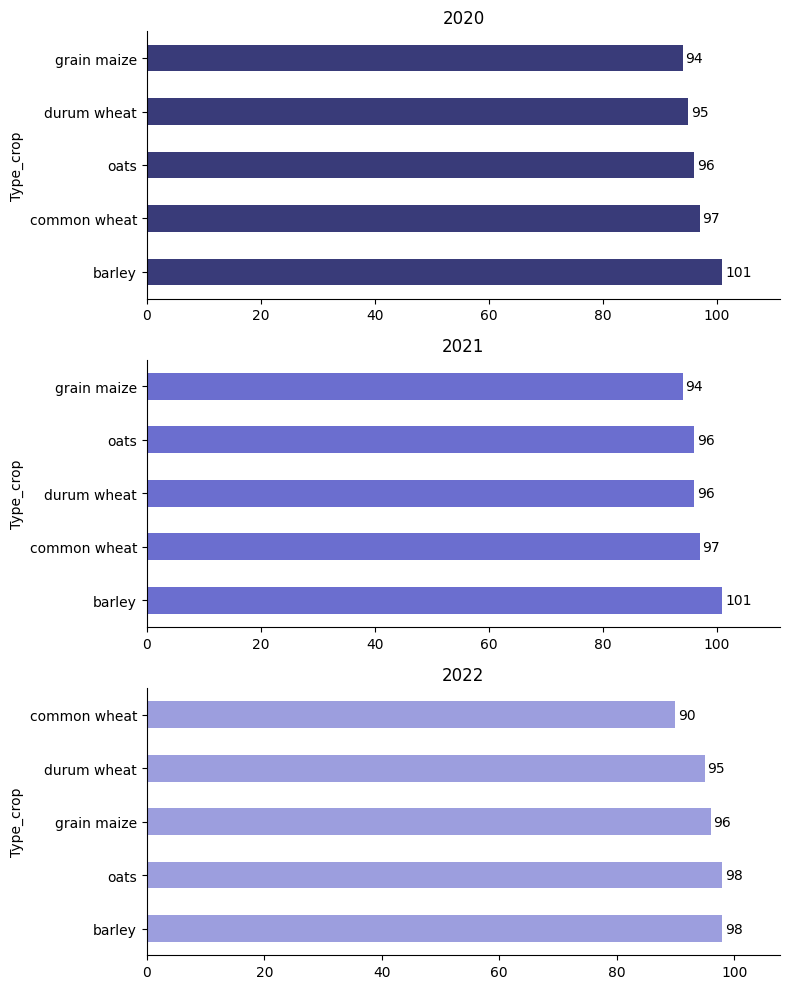

In [20]:
fig, axs = plt.subplots(3, figsize=(8, 10))

plot1 = cereals_top5[cereals_top5.Year == 2020].groupby('Type_crop').size().nlargest(5).plot(kind='barh', color='#393b79', title='2020', ax=axs[0])
plot2 = cereals_top5[cereals_top5.Year == 2021].groupby('Type_crop').size().nlargest(5).plot(kind='barh', color='#6b6ecf', title='2021', ax=axs[1])
plot3 = cereals_top5[cereals_top5.Year == 2022].groupby('Type_crop').size().nlargest(5).plot(kind='barh', color='#9c9ede', title='2022', ax=axs[2])

for ax in axs.flat:
    ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=2)
    ax.margins(x=0.1)
sns.despine()
plt.tight_layout()
plt.show()

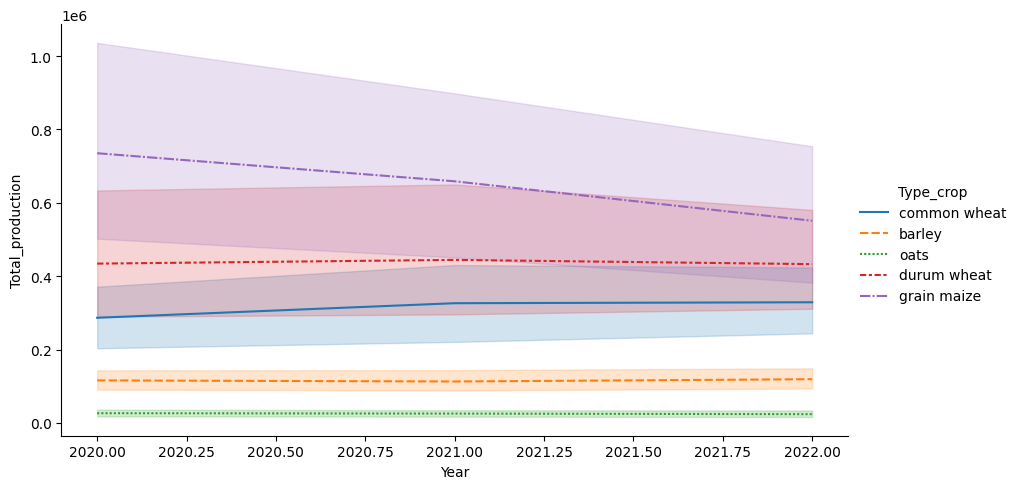

In [21]:
#Crop harvested by year
plotcrop5 = sns.relplot(kind='line', data=cereals_top5, x='Year', y='Total_production', hue='Type_crop', style='Type_crop', aspect=1.75)


In [22]:
# Select year 2020 for future join with fertilizer
it_crop2020 = cereals_top5[cereals_top5['Year'] == 2020]
it_crop2020



,City,Type_crop,Year,Total_production
3,Torino,common wheat,2020,844910
12,Vercelli,common wheat,2020,64250
21,Biella,common wheat,2020,5590
30,Verbano-Cusio-Ossola,common wheat,2020,130
39,Novara,common wheat,2020,60550
...,...,...,...,...
8605,Sud Sardegna,durum wheat,2020,396335
8614,Bolzano / Bozen,common wheat,2020,1400
8632,Bolzano / Bozen,barley,2020,2205
8641,Bolzano / Bozen,oats,2020,352


In [23]:
# Create columns for each type of fertilizer 
it_crop2020_pivot = it_crop2020.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_crop',values=['Total_production'])
it_crop2020_pivot




Total_production                                       \
Type_crop                    barley common wheat durum wheat grain maize   
City          Year                                                         
Abruzzo       2020         701200.0     915055.0   1272250.0    640900.0   
Agrigento     2020          21600.0          NaN    575100.0         NaN   
Alessandria   2020         277530.0     997605.0     75560.0   2336125.0   
Ancona        2020         115611.0       9008.0   2036568.0    196603.0   
Arezzo        2020         117000.0     247000.0    129000.0    147000.0   
...                             ...          ...         ...         ...   
Vercelli      2020          44110.0      64250.0       583.0   1114320.0   
Verona        2020         214925.0     914350.0     87980.0   3010230.0   
Vibo Valentia 2020          13500.0      34800.0     33000.0     27900.0   
Vicenza       2020         158750.0     459370.0     32240.0   1688515.0   
Viterbo       2020         555000.0     136000.0    749000.0    178000.0   

                             
Type_crop              oats  
City          Year           
Abruzzo       2020  68600.0  
Agrigento     2020  18500.0  
Alessandria   2020  13475.0  
Ancona        2020   1555.0  
Arezzo        2020  14300.0  
...                     ...  
Vercelli      2020   2650.0  
Verona        2020    900.0  
Vibo Valentia 2020  44200.0  
Vicenza       2020   1240.0  
Viterbo       2020  31100.0  

[106 rows x 5 columns]

In [24]:

# Drop level
it_crop2020_pivot.columns = it_crop2020_pivot.columns.droplevel()
it_crop2020_pivot



,Type_crop,barley,common wheat,durum wheat,grain maize,oats
City,Year,,,,,
Abruzzo,2020,701200.0,915055.0,1272250.0,640900.0,68600.0
Agrigento,2020,21600.0,NaN,575100.0,NaN,18500.0
Alessandria,2020,277530.0,997605.0,75560.0,2336125.0,13475.0
Ancona,2020,115611.0,9008.0,2036568.0,196603.0,1555.0
Arezzo,2020,117000.0,247000.0,129000.0,147000.0,14300.0
...,...,...,...,...,...,...
Vercelli,2020,44110.0,64250.0,583.0,1114320.0,2650.0
Verona,2020,214925.0,914350.0,87980.0,3010230.0,900.0
Vibo Valentia,2020,13500.0,34800.0,33000.0,27900.0,44200.0


In [25]:
it_crop2020_pivot = it_crop2020_pivot.fillna(0)
it_crop2020_pivot



,Type_crop,barley,common wheat,durum wheat,grain maize,oats
City,Year,,,,,
Abruzzo,2020,701200.0,915055.0,1272250.0,640900.0,68600.0
Agrigento,2020,21600.0,0.0,575100.0,0.0,18500.0
Alessandria,2020,277530.0,997605.0,75560.0,2336125.0,13475.0
Ancona,2020,115611.0,9008.0,2036568.0,196603.0,1555.0
Arezzo,2020,117000.0,247000.0,129000.0,147000.0,14300.0
...,...,...,...,...,...,...
Vercelli,2020,44110.0,64250.0,583.0,1114320.0,2650.0
Verona,2020,214925.0,914350.0,87980.0,3010230.0,900.0
Vibo Valentia,2020,13500.0,34800.0,33000.0,27900.0,44200.0


In [26]:
#Rename index
it_crop2020_pivot = it_crop2020_pivot.rename_axis(None,axis=1)
it_crop2020_pivot



,,barley,common wheat,durum wheat,grain maize,oats
City,Year,,,,,
Abruzzo,2020,701200.0,915055.0,1272250.0,640900.0,68600.0
Agrigento,2020,21600.0,0.0,575100.0,0.0,18500.0
Alessandria,2020,277530.0,997605.0,75560.0,2336125.0,13475.0
Ancona,2020,115611.0,9008.0,2036568.0,196603.0,1555.0
Arezzo,2020,117000.0,247000.0,129000.0,147000.0,14300.0
...,...,...,...,...,...,...
Vercelli,2020,44110.0,64250.0,583.0,1114320.0,2650.0
Verona,2020,214925.0,914350.0,87980.0,3010230.0,900.0
Vibo Valentia,2020,13500.0,34800.0,33000.0,27900.0,44200.0


In [27]:
# Reset index
it_crop2020_pivot = it_crop2020_pivot.reset_index()
it_crop2020_pivot

,City,Year,barley,common wheat,durum wheat,grain maize,oats
0,Abruzzo,2020,701200.0,915055.0,1272250.0,640900.0,68600.0
1,Agrigento,2020,21600.0,0.0,575100.0,0.0,18500.0
2,Alessandria,2020,277530.0,997605.0,75560.0,2336125.0,13475.0
3,Ancona,2020,115611.0,9008.0,2036568.0,196603.0,1555.0
4,Arezzo,2020,117000.0,247000.0,129000.0,147000.0,14300.0
...,...,...,...,...,...,...,...
101,Vercelli,2020,44110.0,64250.0,583.0,1114320.0,2650.0
102,Verona,2020,214925.0,914350.0,87980.0,3010230.0,900.0
103,Vibo Valentia,2020,13500.0,34800.0,33000.0,27900.0,44200.0
104,Vicenza,2020,158750.0,459370.0,32240.0,1688515.0,1240.0


## Crop selection 2021

In [28]:
# Select year 2020 for future join with fertilizer
it_crop2021 = cereals_top5[cereals_top5['Year'] == 2021]
it_crop2021



,City,Type_crop,Year,Total_production
4,Torino,common wheat,2021,925705
13,Vercelli,common wheat,2021,74550
22,Biella,common wheat,2021,15356
31,Verbano-Cusio-Ossola,common wheat,2021,125
40,Novara,common wheat,2021,75950
...,...,...,...,...
8606,Sud Sardegna,durum wheat,2021,529123
8615,Bolzano / Bozen,common wheat,2021,3000
8633,Bolzano / Bozen,barley,2021,1890
8642,Bolzano / Bozen,oats,2021,352


In [29]:
# Create columns for each type of fertilizer 
it_crop2021_pivot = it_crop2021.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_crop',values=['Total_production'])
it_crop2021_pivot




Total_production                                       \
Type_crop                    barley common wheat durum wheat grain maize   
City          Year                                                         
Abruzzo       2021         701200.0     915055.0   1275250.0    641080.0   
Agrigento     2021          20000.0          NaN    549500.0         NaN   
Alessandria   2021         186410.0    1469965.0     69120.0   2065125.0   
Ancona        2021         115611.0       9008.0   2036568.0    196603.0   
Arezzo        2021          88500.0     208000.0    150000.0    133000.0   
...                             ...          ...         ...         ...   
Vercelli      2021          39532.0      74550.0       742.0   1124280.0   
Verona        2021         212610.0    1171023.0    137480.0   2515950.0   
Vibo Valentia 2021          13500.0      34800.0     33000.0     27900.0   
Vicenza       2021         149200.0     591750.0     49910.0   1425640.0   
Viterbo       2021         540000.0     129000.0    740000.0    172500.0   

                             
Type_crop              oats  
City          Year           
Abruzzo       2021  68600.0  
Agrigento     2021  17700.0  
Alessandria   2021  13335.0  
Ancona        2021   1555.0  
Arezzo        2021   6760.0  
...                     ...  
Vercelli      2021    114.0  
Verona        2021    968.0  
Vibo Valentia 2021  44200.0  
Vicenza       2021   1395.0  
Viterbo       2021  30100.0  

[106 rows x 5 columns]

In [30]:

# Drop level
it_crop2021_pivot.columns = it_crop2021_pivot.columns.droplevel()
it_crop2021_pivot



,Type_crop,barley,common wheat,durum wheat,grain maize,oats
City,Year,,,,,
Abruzzo,2021,701200.0,915055.0,1275250.0,641080.0,68600.0
Agrigento,2021,20000.0,NaN,549500.0,NaN,17700.0
Alessandria,2021,186410.0,1469965.0,69120.0,2065125.0,13335.0
Ancona,2021,115611.0,9008.0,2036568.0,196603.0,1555.0
Arezzo,2021,88500.0,208000.0,150000.0,133000.0,6760.0
...,...,...,...,...,...,...
Vercelli,2021,39532.0,74550.0,742.0,1124280.0,114.0
Verona,2021,212610.0,1171023.0,137480.0,2515950.0,968.0
Vibo Valentia,2021,13500.0,34800.0,33000.0,27900.0,44200.0


In [31]:
it_crop2021_pivot = it_crop2021_pivot.fillna(0)
it_crop2021_pivot



,Type_crop,barley,common wheat,durum wheat,grain maize,oats
City,Year,,,,,
Abruzzo,2021,701200.0,915055.0,1275250.0,641080.0,68600.0
Agrigento,2021,20000.0,0.0,549500.0,0.0,17700.0
Alessandria,2021,186410.0,1469965.0,69120.0,2065125.0,13335.0
Ancona,2021,115611.0,9008.0,2036568.0,196603.0,1555.0
Arezzo,2021,88500.0,208000.0,150000.0,133000.0,6760.0
...,...,...,...,...,...,...
Vercelli,2021,39532.0,74550.0,742.0,1124280.0,114.0
Verona,2021,212610.0,1171023.0,137480.0,2515950.0,968.0
Vibo Valentia,2021,13500.0,34800.0,33000.0,27900.0,44200.0


In [32]:
#Rename index
it_crop2021_pivot = it_crop2021_pivot.rename_axis(None,axis=1)
it_crop2021_pivot



,,barley,common wheat,durum wheat,grain maize,oats
City,Year,,,,,
Abruzzo,2021,701200.0,915055.0,1275250.0,641080.0,68600.0
Agrigento,2021,20000.0,0.0,549500.0,0.0,17700.0
Alessandria,2021,186410.0,1469965.0,69120.0,2065125.0,13335.0
Ancona,2021,115611.0,9008.0,2036568.0,196603.0,1555.0
Arezzo,2021,88500.0,208000.0,150000.0,133000.0,6760.0
...,...,...,...,...,...,...
Vercelli,2021,39532.0,74550.0,742.0,1124280.0,114.0
Verona,2021,212610.0,1171023.0,137480.0,2515950.0,968.0
Vibo Valentia,2021,13500.0,34800.0,33000.0,27900.0,44200.0


In [33]:
# Reset index
it_crop2021_pivot = it_crop2021_pivot.reset_index()
it_crop2021_pivot

,City,Year,barley,common wheat,durum wheat,grain maize,oats
0,Abruzzo,2021,701200.0,915055.0,1275250.0,641080.0,68600.0
1,Agrigento,2021,20000.0,0.0,549500.0,0.0,17700.0
2,Alessandria,2021,186410.0,1469965.0,69120.0,2065125.0,13335.0
3,Ancona,2021,115611.0,9008.0,2036568.0,196603.0,1555.0
4,Arezzo,2021,88500.0,208000.0,150000.0,133000.0,6760.0
...,...,...,...,...,...,...,...
101,Vercelli,2021,39532.0,74550.0,742.0,1124280.0,114.0
102,Verona,2021,212610.0,1171023.0,137480.0,2515950.0,968.0
103,Vibo Valentia,2021,13500.0,34800.0,33000.0,27900.0,44200.0
104,Vicenza,2021,149200.0,591750.0,49910.0,1425640.0,1395.0


### Pre-processing ferlizers dataset

In [34]:
fertilizer = pd.read_csv('italy_fertilizers.csv',skipinitialspace=True)
fertilizer.head()

,ITTER107,Territory,TIPO_DATO5,Data type,FERTILIZZANTI,Type of fertilizer,TIME,Select time,Value,Flag Codes,Flags
0,ITD59,Rimini,FERT_DISTRIB_T,fertilizers distributed - tonnes,CON_MIN_MICRO,containing micronutrients,2019,2019,11,NaN,NaN
1,ITD59,Rimini,FERT_DISTRIB_T,fertilizers distributed - tonnes,CON_MIN_MICRO,containing micronutrients,2020,2020,11,NaN,NaN
2,ITD59,Rimini,FERT_DISTRIB_T,fertilizers distributed - tonnes,CON_MIN_MICRO,containing micronutrients,2021,2021,3,NaN,NaN
3,ITD44,Trieste,FERT_DISTRIB_T,fertilizers distributed - tonnes,AMM_TORB_COMP,peaty soil amendment,2019,2019,8,NaN,NaN
4,ITD44,Trieste,FERT_DISTRIB_T,fertilizers distributed - tonnes,AMM_TORB_COMP,peaty soil amendment,2020,2020,105,NaN,NaN


In [35]:
fertilizer = fertilizer.drop(columns =['ITTER107','TIPO_DATO5', 'TIME','FERTILIZZANTI','Flag Codes','Flags' ])
fertilizer

,Territory,Data type,Type of fertilizer,Select time,Value
0,Rimini,fertilizers distributed - tonnes,containing micronutrients,2019,11
1,Rimini,fertilizers distributed - tonnes,containing micronutrients,2020,11
2,Rimini,fertilizers distributed - tonnes,containing micronutrients,2021,3
3,Trieste,fertilizers distributed - tonnes,peaty soil amendment,2019,8
4,Trieste,fertilizers distributed - tonnes,peaty soil amendment,2020,105
...,...,...,...,...,...
17670,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,422
17671,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2021,543
17672,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
17673,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [36]:
#fertilizer.Territory.unique()

In [37]:
# change name of columns
fertilizer = fertilizer.rename(columns = {'Select time':'Year', 'Type of fertilizer':'Type_fertilizer', 'Data type':'Data_type', 'Territory':'City', 'Value':'Fertilizers_tonnes'})
fertilizer

,City,Data_type,Type_fertilizer,Year,Fertilizers_tonnes
0,Rimini,fertilizers distributed - tonnes,containing micronutrients,2019,11
1,Rimini,fertilizers distributed - tonnes,containing micronutrients,2020,11
2,Rimini,fertilizers distributed - tonnes,containing micronutrients,2021,3
3,Trieste,fertilizers distributed - tonnes,peaty soil amendment,2019,8
4,Trieste,fertilizers distributed - tonnes,peaty soil amendment,2020,105
...,...,...,...,...,...
17670,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,422
17671,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2021,543
17672,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
17673,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [38]:
# drop column 
fertilizer = fertilizer.drop(columns =['Data_type'])
fertilizer

,City,Type_fertilizer,Year,Fertilizers_tonnes
0,Rimini,containing micronutrients,2019,11
1,Rimini,containing micronutrients,2020,11
2,Rimini,containing micronutrients,2021,3
3,Trieste,peaty soil amendment,2019,8
4,Trieste,peaty soil amendment,2020,105
...,...,...,...,...
17670,Sud Sardegna,specific action products -,2020,422
17671,Sud Sardegna,specific action products -,2021,543
17672,Sud Sardegna,specific action products -,2019,164
17673,Sud Sardegna,specific action products -,2020,135


## Select fertilizer for 2020


In [39]:
# Select year 2020 for future join with fertilizer
fertilizer2020 = fertilizer[fertilizer['Year'] == 2020]
fertilizer2020

,City,Type_fertilizer,Year,Fertilizers_tonnes
1,Rimini,containing micronutrients,2020,11
4,Trieste,peaty soil amendment,2020,105
7,Pisa,specific action products,2020,27
10,Pordenone,three components - nitrogen-phosphorous-phosph...,2020,8547
13,Venezia,soil correctives - sulphur for agricultural use,2020,5
...,...,...,...,...
17661,Sud Sardegna,soil correctives - other soil correctives,2020,2
17664,Sud Sardegna,crop substrates,2020,112
17667,Sud Sardegna,specific action products,2020,557
17670,Sud Sardegna,specific action products -,2020,422


### Selecting only 6 type of fertilizers for future analysis 

In [40]:
#fertilizer2020.Type_fertilizer.unique()

In [41]:
#print(fertilizer2020.Type_fertilizer.max())
#print(fertilizer2020.Type_fertilizer.value_counts())
#print(fertilizer2020.Type_fertilizer.nunique())

In [42]:
fertilizer2020 = fertilizer2020.apply(lambda row: row[fertilizer2020['Type_fertilizer'].isin(['nitrogen fertilizers','potassium fertilizers',
                                                                                   'organic fertilizers', 'phosphorus fertilizers',
                                                                                   'calcium cyanamide', 'ammonium sulphate'])])

fertilizer2020.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
76,Pavia,ammonium sulphate,2020,747
154,Benevento,calcium cyanamide,2020,0
166,Treviso,ammonium sulphate,2020,1423
172,Provincia Autonoma Bolzano / Bozen,nitrogen fertilizers,2020,31
235,Alessandria,organic fertilizers,2020,2251


#### Create new dataframe with the selected type of fertilizers as columns  

In [43]:
# Create columns for each type of fertilizer 
fertilizer2020_pivot = fertilizer2020.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_fertilizer',values=['Fertilizers_tonnes'])
fertilizer2020_pivot

Fertilizers_tonnes                                         \
Type_fertilizer     ammonium sulphate calcium cyanamide nitrogen fertilizers   
City          Year                                                             
Agrigento     2020                155                12                 1715   
Alessandria   2020                135               105                20968   
Ancona        2020                567                17                22511   
Arezzo        2020                 68                26                 3675   
Ascoli Piceno 2020                  8               158                 1065   
...                               ...               ...                  ...   
Vercelli      2020                 14              2570                 7604   
Verona        2020               3919               258                66460   
Vibo Valentia 2020               1433                 0                 2487   
Vicenza       2020               1350               225                10182   
Viterbo       2020                176                 0                14138   

                                                               \
Type_fertilizer    organic fertilizers phosphorus fertilizers   
City          Year                                              
Agrigento     2020                4006                    142   
Alessandria   2020                2251                    782   
Ancona        2020                2695                   1258   
Arezzo        2020                2053                     72   
Ascoli Piceno 2020                1284                     22   
...                                ...                    ...   
Vercelli      2020                6585                      0   
Verona        2020                9529                   9363   
Vibo Valentia 2020                  92                    157   
Vicenza       2020                1252                    220   
Viterbo       2020                2673                    603   

                                          
Type_fertilizer    potassium fertilizers  
City          Year                        
Agrigento     2020                    16  
Alessandria   2020                   743  
Ancona        2020                    33  
Arezzo        2020                   209  
Ascoli Piceno 2020                   267  
...                                  ...  
Vercelli      2020                  1013  
Verona        2020                  6141  
Vibo Valentia 2020                     0  
Vicenza       2020                   351  
Viterbo       2020                    10  

[108 rows x 6 columns]

In [44]:
# Drop level
fertilizer2020_pivot.columns = fertilizer2020_pivot.columns.droplevel()
fertilizer2020_pivot

,Type_fertilizer,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
City,Year,,,,,,
Agrigento,2020,155,12,1715,4006,142,16
Alessandria,2020,135,105,20968,2251,782,743
Ancona,2020,567,17,22511,2695,1258,33
Arezzo,2020,68,26,3675,2053,72,209
Ascoli Piceno,2020,8,158,1065,1284,22,267
...,...,...,...,...,...,...,...
Vercelli,2020,14,2570,7604,6585,0,1013
Verona,2020,3919,258,66460,9529,9363,6141
Vibo Valentia,2020,1433,0,2487,92,157,0


In [45]:
#Rename index
fertilizer2020_pivot = fertilizer2020_pivot.rename_axis(None,axis=1)
fertilizer2020_pivot

,,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
City,Year,,,,,,
Agrigento,2020,155,12,1715,4006,142,16
Alessandria,2020,135,105,20968,2251,782,743
Ancona,2020,567,17,22511,2695,1258,33
Arezzo,2020,68,26,3675,2053,72,209
Ascoli Piceno,2020,8,158,1065,1284,22,267
...,...,...,...,...,...,...,...
Vercelli,2020,14,2570,7604,6585,0,1013
Verona,2020,3919,258,66460,9529,9363,6141
Vibo Valentia,2020,1433,0,2487,92,157,0


In [46]:
# Reset index
fertilizer2020_pivot = fertilizer2020_pivot.reset_index()
fertilizer2020_pivot

,City,Year,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
0,Agrigento,2020,155,12,1715,4006,142,16
1,Alessandria,2020,135,105,20968,2251,782,743
2,Ancona,2020,567,17,22511,2695,1258,33
3,Arezzo,2020,68,26,3675,2053,72,209
4,Ascoli Piceno,2020,8,158,1065,1284,22,267
...,...,...,...,...,...,...,...,...
103,Vercelli,2020,14,2570,7604,6585,0,1013
104,Verona,2020,3919,258,66460,9529,9363,6141
105,Vibo Valentia,2020,1433,0,2487,92,157,0
106,Vicenza,2020,1350,225,10182,1252,220,351


#### Join crop and fertilizers datasets 

In [47]:
# Join both datasets 
it_crop_ferlizer2020 = pd.merge(it_crop2020_pivot, fertilizer2020_pivot, on=['Year', 'City'], how='left').fillna(0)
it_crop_ferlizer2020

,City,Year,barley,common wheat,durum wheat,grain maize,oats,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
0,Abruzzo,2020,701200.0,915055.0,1272250.0,640900.0,68600.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Agrigento,2020,21600.0,0.0,575100.0,0.0,18500.0,155.0,12.0,1715.0,4006.0,142.0,16.0
2,Alessandria,2020,277530.0,997605.0,75560.0,2336125.0,13475.0,135.0,105.0,20968.0,2251.0,782.0,743.0
3,Ancona,2020,115611.0,9008.0,2036568.0,196603.0,1555.0,567.0,17.0,22511.0,2695.0,1258.0,33.0
4,Arezzo,2020,117000.0,247000.0,129000.0,147000.0,14300.0,68.0,26.0,3675.0,2053.0,72.0,209.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,Vercelli,2020,44110.0,64250.0,583.0,1114320.0,2650.0,14.0,2570.0,7604.0,6585.0,0.0,1013.0
102,Verona,2020,214925.0,914350.0,87980.0,3010230.0,900.0,3919.0,258.0,66460.0,9529.0,9363.0,6141.0
103,Vibo Valentia,2020,13500.0,34800.0,33000.0,27900.0,44200.0,1433.0,0.0,2487.0,92.0,157.0,0.0
104,Vicenza,2020,158750.0,459370.0,32240.0,1688515.0,1240.0,1350.0,225.0,10182.0,1252.0,220.0,351.0


## Select fertilizer for 2021


In [48]:
# Select year 2020 for future join with fertilizer
fertilizer2021 = fertilizer[fertilizer['Year'] == 2021]
fertilizer2021

,City,Type_fertilizer,Year,Fertilizers_tonnes
2,Rimini,containing micronutrients,2021,3
5,Trieste,peaty soil amendment,2021,0
8,Pisa,specific action products,2021,33
11,Pordenone,three components - nitrogen-phosphorous-phosph...,2021,8286
14,Venezia,soil correctives - sulphur for agricultural use,2021,95
...,...,...,...,...
17662,Sud Sardegna,soil correctives - other soil correctives,2021,4
17665,Sud Sardegna,crop substrates,2021,40
17668,Sud Sardegna,specific action products,2021,736
17671,Sud Sardegna,specific action products -,2021,543


### Selecting only 6 type of fertilizers for future analysis 

In [49]:
#fertilizer2021.Type_fertilizer.unique()

In [50]:
#print(fertilizer2021.Type_fertilizer.max())
#print(fertilizer2021.Type_fertilizer.value_counts())
#print(fertilizer2021.Type_fertilizer.nunique())

In [51]:
fertilizer2021 = fertilizer2021.apply(lambda row: row[fertilizer2021['Type_fertilizer'].isin(['nitrogen fertilizers','potassium fertilizers',
                                                                                   'organic fertilizers', 'phosphorus fertilizers',
                                                                                   'calcium cyanamide', 'ammonium sulphate'])])

fertilizer2021.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
77,Pavia,ammonium sulphate,2021,2504
155,Benevento,calcium cyanamide,2021,0
167,Treviso,ammonium sulphate,2021,1541
173,Provincia Autonoma Bolzano / Bozen,nitrogen fertilizers,2021,28
236,Alessandria,organic fertilizers,2021,3930


#### Create new dataframe with the selected type of fertilizers as columns  

In [52]:
# Create columns for each type of fertilizer 
fertilizer2021_pivot = fertilizer2021.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_fertilizer',values=['Fertilizers_tonnes'])
fertilizer2021_pivot

Fertilizers_tonnes                                         \
Type_fertilizer     ammonium sulphate calcium cyanamide nitrogen fertilizers   
City          Year                                                             
Agrigento     2021                738                12                 4592   
Alessandria   2021                151               105                21951   
Ancona        2021                954                17                14630   
Arezzo        2021                 32                27                 2414   
Ascoli Piceno 2021                  3               158                 1610   
...                               ...               ...                  ...   
Vercelli      2021                  5              2571                 8929   
Verona        2021               7632               258                59389   
Vibo Valentia 2021                518                 0                 1498   
Vicenza       2021               1784               226                 6690   
Viterbo       2021                152                 0                11245   

                                                               \
Type_fertilizer    organic fertilizers phosphorus fertilizers   
City          Year                                              
Agrigento     2021                3668                   1075   
Alessandria   2021                3930                    900   
Ancona        2021                2500                   1809   
Arezzo        2021                2174                     71   
Ascoli Piceno 2021                1211                      8   
...                                ...                    ...   
Vercelli      2021                8312                    225   
Verona        2021               10023                  12968   
Vibo Valentia 2021                  61                    185   
Vicenza       2021                1634                   1100   
Viterbo       2021                2199                    587   

                                          
Type_fertilizer    potassium fertilizers  
City          Year                        
Agrigento     2021                    36  
Alessandria   2021                   713  
Ancona        2021                    43  
Arezzo        2021                     8  
Ascoli Piceno 2021                    46  
...                                  ...  
Vercelli      2021                  1014  
Verona        2021                 10878  
Vibo Valentia 2021                     0  
Vicenza       2021                   382  
Viterbo       2021                    11  

[108 rows x 6 columns]

In [53]:
# Drop level
fertilizer2021_pivot.columns = fertilizer2021_pivot.columns.droplevel()
fertilizer2021_pivot

,Type_fertilizer,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
City,Year,,,,,,
Agrigento,2021,738,12,4592,3668,1075,36
Alessandria,2021,151,105,21951,3930,900,713
Ancona,2021,954,17,14630,2500,1809,43
Arezzo,2021,32,27,2414,2174,71,8
Ascoli Piceno,2021,3,158,1610,1211,8,46
...,...,...,...,...,...,...,...
Vercelli,2021,5,2571,8929,8312,225,1014
Verona,2021,7632,258,59389,10023,12968,10878
Vibo Valentia,2021,518,0,1498,61,185,0


In [54]:
#Rename index
fertilizer2021_pivot = fertilizer2021_pivot.rename_axis(None,axis=1)
fertilizer2021_pivot

,,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
City,Year,,,,,,
Agrigento,2021,738,12,4592,3668,1075,36
Alessandria,2021,151,105,21951,3930,900,713
Ancona,2021,954,17,14630,2500,1809,43
Arezzo,2021,32,27,2414,2174,71,8
Ascoli Piceno,2021,3,158,1610,1211,8,46
...,...,...,...,...,...,...,...
Vercelli,2021,5,2571,8929,8312,225,1014
Verona,2021,7632,258,59389,10023,12968,10878
Vibo Valentia,2021,518,0,1498,61,185,0


In [55]:
# Reset index
fertilizer2021_pivot = fertilizer2021_pivot.reset_index()
fertilizer2021_pivot

,City,Year,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
0,Agrigento,2021,738,12,4592,3668,1075,36
1,Alessandria,2021,151,105,21951,3930,900,713
2,Ancona,2021,954,17,14630,2500,1809,43
3,Arezzo,2021,32,27,2414,2174,71,8
4,Ascoli Piceno,2021,3,158,1610,1211,8,46
...,...,...,...,...,...,...,...,...
103,Vercelli,2021,5,2571,8929,8312,225,1014
104,Verona,2021,7632,258,59389,10023,12968,10878
105,Vibo Valentia,2021,518,0,1498,61,185,0
106,Vicenza,2021,1784,226,6690,1634,1100,382


#### Join crop and fertilizers datasets 

In [56]:
# Join both datasets 
it_crop_ferlizer2021 = pd.merge(it_crop2021_pivot, fertilizer2021_pivot, on=['Year', 'City'], how='left').fillna(0)
it_crop_ferlizer2021

,City,Year,barley,common wheat,durum wheat,grain maize,oats,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
0,Abruzzo,2021,701200.0,915055.0,1275250.0,641080.0,68600.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Agrigento,2021,20000.0,0.0,549500.0,0.0,17700.0,738.0,12.0,4592.0,3668.0,1075.0,36.0
2,Alessandria,2021,186410.0,1469965.0,69120.0,2065125.0,13335.0,151.0,105.0,21951.0,3930.0,900.0,713.0
3,Ancona,2021,115611.0,9008.0,2036568.0,196603.0,1555.0,954.0,17.0,14630.0,2500.0,1809.0,43.0
4,Arezzo,2021,88500.0,208000.0,150000.0,133000.0,6760.0,32.0,27.0,2414.0,2174.0,71.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,Vercelli,2021,39532.0,74550.0,742.0,1124280.0,114.0,5.0,2571.0,8929.0,8312.0,225.0,1014.0
102,Verona,2021,212610.0,1171023.0,137480.0,2515950.0,968.0,7632.0,258.0,59389.0,10023.0,12968.0,10878.0
103,Vibo Valentia,2021,13500.0,34800.0,33000.0,27900.0,44200.0,518.0,0.0,1498.0,61.0,185.0,0.0
104,Vicenza,2021,149200.0,591750.0,49910.0,1425640.0,1395.0,1784.0,226.0,6690.0,1634.0,1100.0,382.0


### Correlation analysis 2020


In [57]:

crop = it_crop_ferlizer2020.City.astype('category')
targets = dict(enumerate(crop.cat.categories))
it_crop_ferlizer2020['target']=crop.cat.codes

cor_selected = it_crop_ferlizer2020[['City','barley','common wheat','durum wheat','grain maize','oats','ammonium sulphate','calcium cyanamide','nitrogen fertilizers',
                       'organic fertilizers','phosphorus fertilizers','potassium fertilizers']]


<AxesSubplot: title={'center': 'Correlation'}>

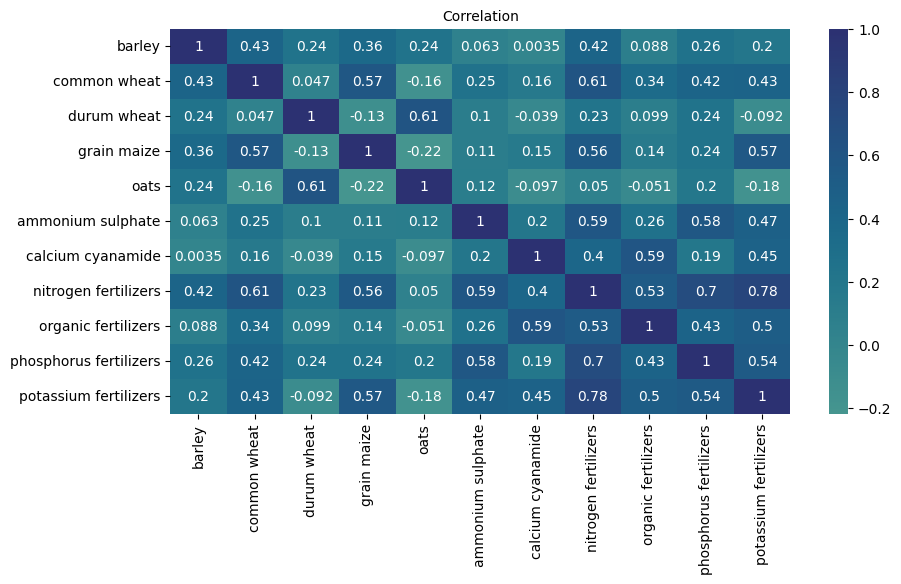

In [61]:
plt.figure(figsize=(10,5))
plt.title('Correlation', size=10)
sns.heatmap(cor_selected.corr(), cmap='crest', center=0, annot=True)

### Correlation analysis of cereal production in Italy 2020: 

* Maize has hight correlation with potassion and nitrogen fertilizers and Wheat.

* Barley has correlation with nitrogen fertilizer and Wheat.

* Common wheat has hight correlation with nitrogen fertilizer and Maize. 

* Oats has hight correlation with Durum Wheat. 

* There is also hight correlation between phosphorus and potassium with nitrogen fertilizer.


### Correlation analysis 2021

In [59]:

crop = it_crop_ferlizer2021.City.astype('category')
targets = dict(enumerate(crop.cat.categories))
it_crop_ferlizer2021['target']=crop.cat.codes

cor_selected = it_crop_ferlizer2021[['City','barley','common wheat','durum wheat','grain maize','oats','ammonium sulphate','calcium cyanamide','nitrogen fertilizers',
                       'organic fertilizers','phosphorus fertilizers','potassium fertilizers']]


<AxesSubplot: title={'center': 'Correlation'}>

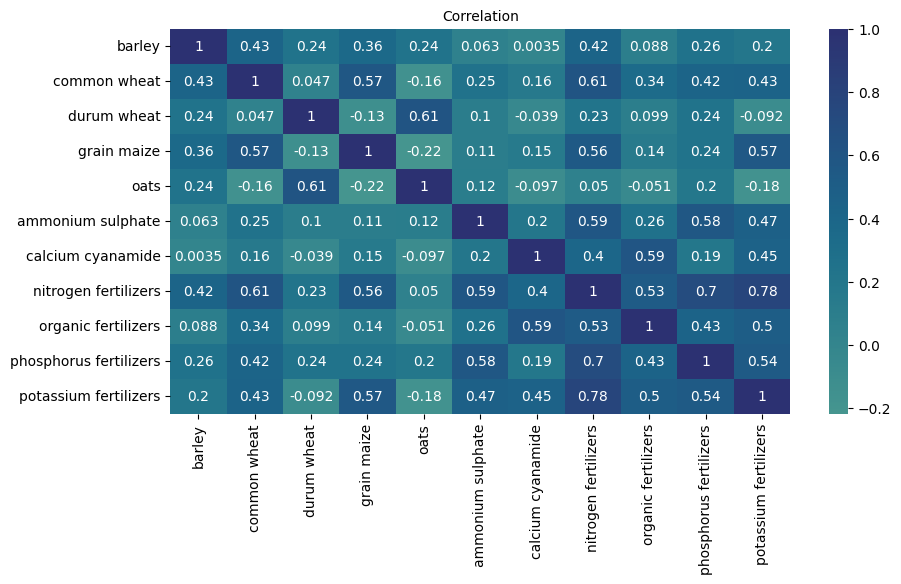

In [62]:
plt.figure(figsize=(10,5))
plt.title('Correlation', size=10)
sns.heatmap(cor_selected.corr(), cmap='crest', center=0, annot=True)

### Correlation analysis of cereal production in Italy 2021: 

* Maize has hight correlation with potassion and nitrogen fertilizers, and Common Wheat.

* Barley has correlation with nitrogen fertilizer, Maize and Common Wheat.

* Durum Wheat has hight correlation with Oats. 

* There is also hight correlation between phosphorus and potassium with nitrogen fertilizer.


Modelling 

# References


http://dati.istat.it

https://maps.princeton.edu/catalog/stanford-mn871sp9778

https://www.crea.gov.it/documents/68457/0/ITACONTA+2020_ENG+DEF+xweb+%281%29.pdf/95c6b30a-1e18-8e94-d4ac-ce884aef76e8?t=1619527317576

https://seaborn.pydata.org/generated/seaborn.relplot.html